In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt

from data_handling.data_loader import load_mavir_data
from trainer_lib import Grid, grid_search
from models import Transformer
import utils

In [2]:
df = load_mavir_data('data/mavir_data/mavir.csv')
df['Power'] = utils.min_max_norm(df['Power'])
sample = utils.sample(df, 1000, start_idx=0)

# imfs, residue = utils.apply_eemd(sample['Power'].to_numpy(), spline_kind='akima')

In [3]:
training_data = np.array(sample['Power'].to_numpy()[...,np.newaxis], dtype=np.float32)
# training_data_decomp = np.array(np.c_[imfs.transpose(), residue[...,np.newaxis]], dtype=np.float32)
# training_data_decomp_rem = np.array(np.c_[imfs[1:].transpose(), residue[...,np.newaxis]], dtype=np.float32)
# training_data_combined = np.array(np.c_[sample['Power'].to_numpy()[...,np.newaxis], imfs.transpose(), residue[...,np.newaxis]], dtype=np.float32)
# training_data_combined_rem = np.array(np.c_[sample['Power'].to_numpy()[...,np.newaxis], imfs[1:].transpose(), residue[...,np.newaxis]], dtype=np.float32)
# print(training_data.shape)
# print(training_data.dtype)
# print(training_data_decomp.shape)
# print(training_data_decomp.dtype)

In [24]:
params = {
    'src_size' : [1*8],
    'tgt_size' : [1*1],
    'd_model' : [256], #, 256, 512],
    'num_heads' : [2], # , 4, 8],
    'num_layers' : [2], # , 2, 3],
    'd_ff' : [512], # , 1024, 2048],
    'enc_seq_length' : [24], # , 96],
    'dec_seq_length' : [1],
    'enc_window': [8],
    'dec_window': [1],
    'dropout' : [0.2], # , 0.1, 0.15, 0.2],
}

grid = Grid(params)
models = grid_search(grid, Transformer, training_data, epochs=50, split=0.01)

776 8
Epoch: 1, Train Loss: 0.2889282847802664, Eval Loss: 0.11633909493684769
Epoch: 2, Train Loss: 0.14969997100301624, Eval Loss: 0.07299963384866714
Epoch: 3, Train Loss: 0.11663102581328957, Eval Loss: 0.07963307946920395
Epoch: 4, Train Loss: 0.1067736337018996, Eval Loss: 0.0908345878124237
Epoch: 5, Train Loss: 0.09307008155996037, Eval Loss: 0.06306498497724533
Epoch: 6, Train Loss: 0.08259014186170911, Eval Loss: 0.0809096172451973
Epoch: 7, Train Loss: 0.07671364903757254, Eval Loss: 0.07633927464485168
Epoch: 8, Train Loss: 0.07209131067868361, Eval Loss: 0.0636555626988411
Epoch: 9, Train Loss: 0.06995542956151297, Eval Loss: 0.05963107571005821
Epoch: 10, Train Loss: 0.06528745320884838, Eval Loss: 0.0627325102686882
Epoch: 11, Train Loss: 0.06313657144218991, Eval Loss: 0.03951206058263779
Epoch: 12, Train Loss: 0.05921513836869259, Eval Loss: 0.06837954372167587
Epoch: 13, Train Loss: 0.05891136099229156, Eval Loss: 0.06042355298995972
Epoch: 14, Train Loss: 0.060603779

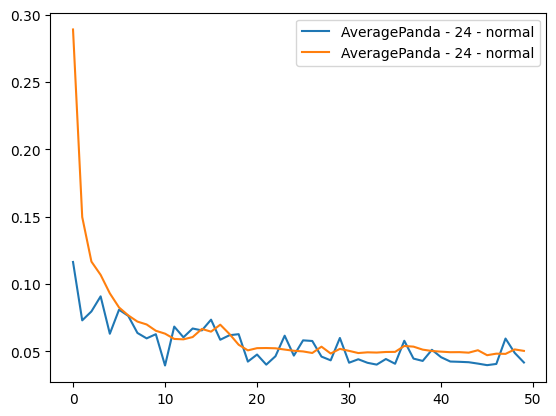

In [25]:

#for model in models_decomp_combined:
#    plt.plot(model['metrics']['eval_loss'], label=f'{model["name"]} - {model["params"]["enc_seq_length"]} - combined')

#for model in models_decomp_combined_rem:
#    plt.plot(model['metrics']['eval_loss'], label=f'{model["name"]} - {model["params"]["enc_seq_length"]} - combined rem')

#for model in models_decomp_rem:
#    plt.plot(model['metrics']['eval_loss'], label=f'{model["name"]} - {model["params"]["enc_seq_length"]} - rem')

#for model in models_decomp:
#    plt.plot(model['metrics']['eval_loss'], label=f'{model["name"]} - {model["params"]["enc_seq_length"]} - decomp')

for model in models:
    plt.plot(model['metrics']['eval_loss'], label=f'{model["name"]} - {model["params"]["enc_seq_length"]} - normal')
    plt.plot(model['metrics']['train_loss'], label=f'{model["name"]} - {model["params"]["enc_seq_length"]} - normal')

plt.legend()
plt.show()

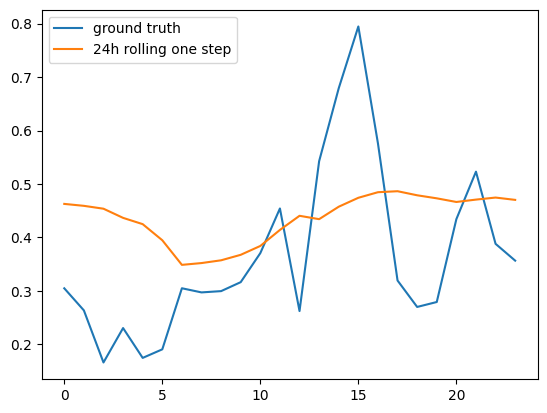

In [33]:
from trainer_lib.datasets import TimeSeriesWindowedTensorDataset, TimeSeriesWindowedDatasetConfig

shift, look_back, pred = 300, 24, 1

dataset = TimeSeriesWindowedTensorDataset(training_data, TimeSeriesWindowedDatasetConfig((8, 1), (24, 1), 1))
ones = torch.ones(1, 1, dataset[0][1].shape[-1])
for model in models:
    model['model'].eval()
    
    ground_truth = []
    predicted = []
    for shift_offset in range(shift, shift+24):
        out = ones
        for i in range(pred):
            out = torch.concatenate((ones, model['model'](dataset[shift_offset][0].unsqueeze(0), out)), dim=1)
    
        predicted.append(dataset.get_sequence_from_y_windows(out[:, 1:, :].detach()))
        ground_truth.append(dataset.get_sequence_from_y_windows(dataset[shift_offset][1]))
    
    predicted = np.array(predicted).reshape(24)
    ground_truth = np.array(ground_truth).reshape(24)
    plt.plot(ground_truth, label='ground truth')
    plt.plot(predicted, label='24h rolling one step')
    
    #output = model['model'](
    #    dataset[shift][0].unsqueeze(0),  
    #    torch.concat((ones, dataset[shift][1][:-1, :].unsqueeze(0)), dim=1)
    #)
    #
    #plt.plot(torch.concat(
    #    (dataset.get_sequence_from_x_windows(dataset[shift][0]), 
    #     dataset.get_sequence_from_y_windows(dataset[shift][1])), dim=0), label='original')
    #plt.plot(
    #    torch.concatenate(
    #        (dataset.get_sequence_from_x_windows(dataset[shift][0]),
    #         dataset.get_sequence_from_y_windows(output[:, :, :].detach())), dim=0), 
    #    label='full access - normal'
    #)
    #plt.plot(
    #    torch.concatenate(
    #        (dataset.get_sequence_from_x_windows(dataset[shift][0]), 
    #         dataset.get_sequence_from_y_windows(out[:, 1:, :].detach())), dim=0),
    #    label='predicted - normal'
    #)
    
#for model in models_decomp:
#    out = torch.ones(1,1,11)
#    for _ in range(25):
#        output = model['model'](torch.tensor(training_data_decomp[np.newaxis, 0:72,:]), out)# torch.tensor(training_data[np.newaxis, 73:97,:]))# torch.zeros((1, 24, 1)))
#        out = torch.concatenate((out, output[:,-1,:].unsqueeze(1)), axis=1)
#    plt.plot(out[:, 1:-1, :].detach().reshape((24,11)).sum(-1), label='predicted - decomp')

#for model in models_decomp_rem:
#    out = torch.ones(1,1,10)
#    for _ in range(25):
#        output = model['model'](torch.tensor(training_data_decomp_rem[np.newaxis, 0:72,:]), out)# torch.tensor(training_data[np.newaxis, 73:97,:]))# torch.zeros((1, 24, 1)))
#        out = torch.concatenate((out, output[:,-1,:].unsqueeze(1)), axis=1)
#    plt.plot(out[:, 1:-1, :].detach().reshape((24,10)).sum(-1), label='predicted - rem')

#for model in models_decomp_combined:
#    out = torch.ones(1,1,1)
#    for _ in range(25):
#        output = model['model'](torch.tensor(training_data_combined[np.newaxis, 0:72,:]), out)# torch.tensor(training_data[np.newaxis, 73:97,:]))# torch.zeros((1, 24, 1)))
#        out = torch.concatenate((out, output[:,-1,:].unsqueeze(1)), axis=1)
#    plt.plot(out[:, 1:-1, :].detach().reshape((24,)), label='predicted - combined')

#for model in models_decomp_combined_rem:
#    out = torch.ones(1,1,1)
#    for _ in range(25):
#        output = model['model'](torch.tensor(training_data_combined_rem[np.newaxis, 0:72,:]), out)# torch.tensor(training_data[np.newaxis, 73:97,:]))# torch.zeros((1, 24, 1)))
#        out = torch.concatenate((out, output[:,-1,:].unsqueeze(1)), axis=1)
#    plt.plot(out[:, 1:-1, :].detach().reshape((24,)), label='predicted - combined rem')

plt.legend()
plt.show()